
- Repeat for different actions - e.i. changing percent to sell or buy all
- Train n-step sarsa (n = 0, n = 2, n = 4, n = 10, n = 20)


- Try negative rewards
    - Repeat for different actions - e.i. changing percent to sell or buy all
    - Train MC and SARSA 
        - Compare which one performs better in training
        - Compare which one performs better on Test time period

- Plot percent of state space experienced
- Plot actions that resulted in Gain - may only be relevant for 100%  buy sell version




### NO SOFTMAX IN ENV

In [21]:


import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
import os
from agents.single_stock_tabular import nstep_sarsa_single_stock, on_policy_mc_control_single_stock

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [22]:

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)

Successfully added technical indicators


In [ ]:
## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583909,607541200,AAPL,2,-0.082603,3.093652,2.454291,42.254764,-80.462684,16.129793,2.749560,2.861671,"[[0.0013489694715624536, 0.0004284126279862658...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839516,6287200,AMGN,2,0.156757,42.707027,40.853198,51.060604,51.523263,10.432018,41.058034,40.603776,"[[0.0013489694715624536, 0.0004284126279862658...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580750,9625600,AXP,2,-0.935582,18.646869,12.660476,42.554852,-75.437685,25.776759,15.744065,17.616375,"[[0.0013489694715624536, 0.0004284126279862658...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005898,5443100,BA,2,-0.279800,32.174388,28.867828,47.440258,156.994983,5.366299,30.327213,32.389915,"[[0.0013489694715624536, 0.0004284126279862658...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608652,6277400,CAT,2,0.655610,30.348088,25.455650,51.205301,98.374129,26.331746,26.689552,26.423593,"[[0.0013489694715624536, 0.0004284126279862658...",tic AAPL AMGN AXP ...


In [ ]:
TRAIN_START = '2009-01-01'
TRAIN_END ='2020-07-01'
TEST_START = '2020-07-01'
TEST_END = '2021-10-31'

train = data_split(df, TRAIN_START, TRAIN_END)
trade = data_split(df,TEST_START, TEST_END)

In [ ]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}


Stock Dimension: 28, State Space: 28


In [ ]:
EPISODES = 2

In [ ]:
n_step_sarsa_env = StockPortfolioEnv(df = train, **env_kwargs)

In [ ]:
two_step_sarsa_post_training_env, two_step_sarsa_training_episodes, two_step_sarsa_Q = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, aggressive=True)

Episode:   0%|          | 1/250 [00:06<27:20,  6.59s/it]

begin_total_asset:1000000
end_total_asset:3589749.0256282534
Sharpe:  0.6439463499015909


Episode:   1%|          | 2/250 [00:12<26:44,  6.47s/it]

begin_total_asset:1000000
end_total_asset:4052954.158800727
Sharpe:  0.7199025948556558


Episode:   1%|          | 3/250 [00:18<25:42,  6.24s/it]

begin_total_asset:1000000
end_total_asset:6569806.716946597
Sharpe:  0.8988129734123811


Episode:   2%|▏         | 4/250 [00:25<26:04,  6.36s/it]

begin_total_asset:1000000
end_total_asset:11700819.88518377
Sharpe:  1.183309219211861


Episode:   2%|▏         | 5/250 [00:32<27:01,  6.62s/it]

begin_total_asset:1000000
end_total_asset:9420384.597407747
Sharpe:  1.1184303130292124


Episode:   2%|▏         | 6/250 [00:38<26:01,  6.40s/it]

begin_total_asset:1000000
end_total_asset:7723397.462621291
Sharpe:  1.0041623564287854


Episode:   3%|▎         | 7/250 [00:44<25:14,  6.23s/it]

begin_total_asset:1000000
end_total_asset:3189108.3518222254
Sharpe:  0.579053423383347


Episode:   3%|▎         | 8/250 [00:51<25:42,  6.38s/it]

begin_total_asset:1000000
end_total_asset:9617598.92969957
Sharpe:  1.0807300293879005


Episode:   4%|▎         | 9/250 [00:57<25:33,  6.36s/it]

begin_total_asset:1000000
end_total_asset:9928518.018792972
Sharpe:  1.1032748543423723


Episode:   4%|▍         | 10/250 [01:03<25:26,  6.36s/it]

begin_total_asset:1000000
end_total_asset:5259552.338184423
Sharpe:  0.8470669916429154


Episode:   4%|▍         | 11/250 [01:10<25:33,  6.42s/it]

begin_total_asset:1000000
end_total_asset:8586170.93030481
Sharpe:  0.9892556361909207


Episode:   5%|▍         | 12/250 [01:17<26:35,  6.70s/it]

begin_total_asset:1000000
end_total_asset:4239162.731880632
Sharpe:  0.7455810381799463


Episode:   5%|▌         | 13/250 [01:23<25:48,  6.54s/it]

begin_total_asset:1000000
end_total_asset:4416007.117540768
Sharpe:  0.7439908454244447


Episode:   6%|▌         | 14/250 [01:29<24:54,  6.33s/it]

begin_total_asset:1000000
end_total_asset:5439540.514977818
Sharpe:  0.8516030251052918


Episode:   6%|▌         | 15/250 [01:36<24:53,  6.36s/it]

begin_total_asset:1000000
end_total_asset:7675528.681315087
Sharpe:  0.958474331335306


Episode:   6%|▋         | 16/250 [01:41<23:56,  6.14s/it]

begin_total_asset:1000000
end_total_asset:6184991.259816622
Sharpe:  0.8783311796488245


Episode:   7%|▋         | 17/250 [01:47<23:56,  6.16s/it]

begin_total_asset:1000000
end_total_asset:4416123.149026775
Sharpe:  0.7528266185147399


Episode:   7%|▋         | 18/250 [01:54<23:53,  6.18s/it]

begin_total_asset:1000000
end_total_asset:10391254.87768584
Sharpe:  1.1216066119200845


Episode:   8%|▊         | 19/250 [02:00<23:22,  6.07s/it]

begin_total_asset:1000000
end_total_asset:4176310.9172145464
Sharpe:  0.7222108212372108


Episode:   8%|▊         | 20/250 [02:05<22:57,  5.99s/it]

begin_total_asset:1000000
end_total_asset:4000629.8128488134
Sharpe:  0.6974246126286252


Episode:   8%|▊         | 21/250 [02:12<23:19,  6.11s/it]

begin_total_asset:1000000
end_total_asset:5542726.080319169
Sharpe:  0.8378618820975705


Episode:   9%|▉         | 22/250 [02:18<23:17,  6.13s/it]

begin_total_asset:1000000
end_total_asset:6854557.796384154
Sharpe:  0.8883383476105698


Episode:   9%|▉         | 23/250 [02:24<23:12,  6.13s/it]

begin_total_asset:1000000
end_total_asset:3867456.5519872177
Sharpe:  0.6974002499488445


Episode:  10%|▉         | 24/250 [02:30<23:13,  6.16s/it]

begin_total_asset:1000000
end_total_asset:3614094.8516408443
Sharpe:  0.7098731441418721


Episode:  10%|█         | 25/250 [02:36<22:47,  6.08s/it]

begin_total_asset:1000000
end_total_asset:6145540.045848598
Sharpe:  0.9126845581675442


Episode:  10%|█         | 26/250 [02:42<22:37,  6.06s/it]

begin_total_asset:1000000
end_total_asset:5602897.801305809
Sharpe:  0.8562416183091844


Episode:  11%|█         | 27/250 [02:49<23:08,  6.23s/it]

begin_total_asset:1000000
end_total_asset:1893073.7780000684
Sharpe:  0.38123776553612027


Episode:  11%|█         | 28/250 [02:55<22:46,  6.15s/it]

begin_total_asset:1000000
end_total_asset:11713279.48076473
Sharpe:  1.1408424652103348


Episode:  12%|█▏        | 29/250 [03:01<22:34,  6.13s/it]

begin_total_asset:1000000
end_total_asset:5675156.138382371
Sharpe:  0.8476494700458548


Episode:  12%|█▏        | 30/250 [03:07<22:11,  6.05s/it]

begin_total_asset:1000000
end_total_asset:8134201.5668463595
Sharpe:  1.0437233117417435


Episode:  12%|█▏        | 31/250 [03:13<22:22,  6.13s/it]

begin_total_asset:1000000
end_total_asset:3232088.57219881
Sharpe:  0.6272395142706095


Episode:  13%|█▎        | 32/250 [03:19<22:01,  6.06s/it]

begin_total_asset:1000000
end_total_asset:7052954.536947245
Sharpe:  0.9563687181449492


Episode:  13%|█▎        | 33/250 [03:25<21:34,  5.96s/it]

begin_total_asset:1000000
end_total_asset:4747464.21078061
Sharpe:  0.7881290754735444


Episode:  14%|█▎        | 34/250 [03:30<21:18,  5.92s/it]

begin_total_asset:1000000
end_total_asset:3377169.4587125424
Sharpe:  0.632088112087976


Episode:  14%|█▍        | 35/250 [03:37<21:32,  6.01s/it]

begin_total_asset:1000000
end_total_asset:5547946.021319849
Sharpe:  0.8414629868833042


Episode:  14%|█▍        | 36/250 [03:43<21:18,  5.97s/it]

begin_total_asset:1000000
end_total_asset:5548711.886197425
Sharpe:  0.8625183965540254


Episode:  15%|█▍        | 37/250 [03:49<21:17,  6.00s/it]

begin_total_asset:1000000
end_total_asset:2693499.7662231033
Sharpe:  0.5311796917128775


Episode:  15%|█▌        | 38/250 [03:54<20:46,  5.88s/it]

begin_total_asset:1000000
end_total_asset:5264932.178568959
Sharpe:  0.8238567728968282


Episode:  16%|█▌        | 39/250 [04:01<21:57,  6.24s/it]

begin_total_asset:1000000
end_total_asset:5783736.651277734
Sharpe:  0.870696264374309


Episode:  16%|█▌        | 40/250 [04:07<21:23,  6.11s/it]

begin_total_asset:1000000
end_total_asset:2700972.422582726
Sharpe:  0.5269025782046854


Episode:  16%|█▋        | 41/250 [04:13<21:03,  6.05s/it]

begin_total_asset:1000000
end_total_asset:11859989.577970348
Sharpe:  1.1795089055601826


Episode:  17%|█▋        | 42/250 [04:19<20:45,  5.99s/it]

begin_total_asset:1000000
end_total_asset:4272141.116864808
Sharpe:  0.7264423091853545


Episode:  17%|█▋        | 43/250 [04:25<20:30,  5.94s/it]

begin_total_asset:1000000
end_total_asset:5460504.9689161945
Sharpe:  0.8145278186208101


Episode:  18%|█▊        | 44/250 [04:30<20:13,  5.89s/it]

begin_total_asset:1000000
end_total_asset:2170941.8195008915
Sharpe:  0.4464390663586666


Episode:  18%|█▊        | 45/250 [04:36<19:59,  5.85s/it]

begin_total_asset:1000000
end_total_asset:3762071.879977049
Sharpe:  0.6752642083226522


Episode:  18%|█▊        | 46/250 [04:42<19:45,  5.81s/it]

begin_total_asset:1000000
end_total_asset:4633107.205281107
Sharpe:  0.8126056070228924


Episode:  19%|█▉        | 47/250 [04:48<19:34,  5.79s/it]

begin_total_asset:1000000
end_total_asset:5377370.881273747
Sharpe:  0.8877946134771055


Episode:  19%|█▉        | 48/250 [04:53<19:24,  5.76s/it]

begin_total_asset:1000000
end_total_asset:2675652.8176642074
Sharpe:  0.5306125920747529


Episode:  20%|█▉        | 49/250 [05:00<19:40,  5.87s/it]

begin_total_asset:1000000
end_total_asset:5204663.369582434
Sharpe:  0.8305670388547617


Episode:  20%|██        | 50/250 [05:06<19:51,  5.96s/it]

begin_total_asset:1000000
end_total_asset:5807175.0027453555
Sharpe:  0.8201697829691155


Episode:  20%|██        | 51/250 [05:13<21:12,  6.39s/it]

begin_total_asset:1000000
end_total_asset:7867755.644967408
Sharpe:  1.024915622861282


Episode:  21%|██        | 52/250 [05:21<22:08,  6.71s/it]

begin_total_asset:1000000
end_total_asset:5892008.801123842
Sharpe:  0.8748022061107573


Episode:  21%|██        | 53/250 [05:28<22:46,  6.94s/it]

begin_total_asset:1000000
end_total_asset:5208758.281953078
Sharpe:  0.8461147464101457


Episode:  22%|██▏       | 54/250 [05:34<21:52,  6.70s/it]

begin_total_asset:1000000
end_total_asset:18759622.3661109
Sharpe:  1.3553508222219317


Episode:  22%|██▏       | 55/250 [05:41<21:39,  6.66s/it]

begin_total_asset:1000000
end_total_asset:3967110.9995206497
Sharpe:  0.6921275128954032


Episode:  22%|██▏       | 56/250 [05:47<21:10,  6.55s/it]

begin_total_asset:1000000
end_total_asset:7744717.113190077
Sharpe:  0.9895520854792768


Episode:  23%|██▎       | 57/250 [05:53<20:27,  6.36s/it]

begin_total_asset:1000000
end_total_asset:7176197.231218795
Sharpe:  0.9476212907178245


Episode:  23%|██▎       | 58/250 [05:59<20:09,  6.30s/it]

begin_total_asset:1000000
end_total_asset:5291357.56775256
Sharpe:  0.8429867262119511


Episode:  24%|██▎       | 59/250 [06:05<19:52,  6.24s/it]

begin_total_asset:1000000
end_total_asset:7298105.091169146
Sharpe:  0.961910330731722


Episode:  24%|██▍       | 60/250 [06:11<19:29,  6.16s/it]

begin_total_asset:1000000
end_total_asset:1736870.1584949074
Sharpe:  0.3486074666389847


Episode:  24%|██▍       | 61/250 [06:17<18:55,  6.01s/it]

begin_total_asset:1000000
end_total_asset:8409469.370190565
Sharpe:  1.0192013126458195


Episode:  25%|██▍       | 62/250 [06:23<19:21,  6.18s/it]

begin_total_asset:1000000
end_total_asset:7670931.792239152
Sharpe:  1.0090608272549486


Episode:  25%|██▌       | 63/250 [06:30<19:23,  6.22s/it]

begin_total_asset:1000000
end_total_asset:5066824.102998693
Sharpe:  0.7981518425490902


Episode:  26%|██▌       | 64/250 [06:36<19:00,  6.13s/it]

begin_total_asset:1000000
end_total_asset:8025264.42625265
Sharpe:  0.9971542081462111


Episode:  26%|██▌       | 65/250 [06:41<18:33,  6.02s/it]

begin_total_asset:1000000
end_total_asset:11807813.276574468
Sharpe:  1.1747824493976653


Episode:  26%|██▋       | 66/250 [06:47<18:06,  5.90s/it]

begin_total_asset:1000000
end_total_asset:1830224.680406659
Sharpe:  0.36016433115636853


Episode:  27%|██▋       | 67/250 [06:53<17:45,  5.82s/it]

begin_total_asset:1000000
end_total_asset:2128629.4581672316
Sharpe:  0.42805537136815425


Episode:  27%|██▋       | 68/250 [06:59<17:44,  5.85s/it]

begin_total_asset:1000000
end_total_asset:2378890.749727304
Sharpe:  0.4767222299131794


Episode:  28%|██▊       | 69/250 [07:05<17:51,  5.92s/it]

begin_total_asset:1000000
end_total_asset:10445249.725359742
Sharpe:  1.089251051257967


Episode:  28%|██▊       | 70/250 [07:10<17:39,  5.89s/it]

begin_total_asset:1000000
end_total_asset:6642130.50331684
Sharpe:  0.8790666393206827


Episode:  28%|██▊       | 71/250 [07:17<17:41,  5.93s/it]

begin_total_asset:1000000
end_total_asset:2840736.3789403196
Sharpe:  0.5604658557381557


Episode:  29%|██▉       | 72/250 [07:22<17:37,  5.94s/it]

begin_total_asset:1000000
end_total_asset:4063252.439736619
Sharpe:  0.7364798675662968


Episode:  29%|██▉       | 73/250 [07:28<17:15,  5.85s/it]

begin_total_asset:1000000
end_total_asset:5834282.3972450085
Sharpe:  0.8591115790092303


Episode:  30%|██▉       | 74/250 [07:34<17:00,  5.80s/it]

begin_total_asset:1000000
end_total_asset:6460843.444231944
Sharpe:  0.899731535916107


Episode:  30%|███       | 75/250 [07:40<17:23,  5.96s/it]

begin_total_asset:1000000
end_total_asset:8394726.962006623
Sharpe:  1.024941790920752


Episode:  30%|███       | 76/250 [07:46<17:27,  6.02s/it]

begin_total_asset:1000000
end_total_asset:10198731.16790373
Sharpe:  1.1146758359833797


Episode:  31%|███       | 77/250 [07:52<17:09,  5.95s/it]

begin_total_asset:1000000
end_total_asset:9699641.554749561
Sharpe:  1.0812713653340706


Episode:  31%|███       | 78/250 [07:58<16:53,  5.89s/it]

begin_total_asset:1000000
end_total_asset:4151170.4834687705
Sharpe:  0.7306042331717711


Episode:  32%|███▏      | 79/250 [08:04<16:46,  5.89s/it]

begin_total_asset:1000000
end_total_asset:7004849.097614299
Sharpe:  0.9948278707587924


Episode:  32%|███▏      | 80/250 [08:10<16:39,  5.88s/it]

begin_total_asset:1000000
end_total_asset:6319801.258494146
Sharpe:  0.8832117238828845


Episode:  32%|███▏      | 81/250 [08:15<16:30,  5.86s/it]

begin_total_asset:1000000
end_total_asset:24441306.567681015
Sharpe:  1.532561624470926


Episode:  33%|███▎      | 82/250 [08:21<16:13,  5.79s/it]

begin_total_asset:1000000
end_total_asset:8783183.038422963
Sharpe:  1.0495697774551158


Episode:  33%|███▎      | 83/250 [08:27<15:56,  5.73s/it]

begin_total_asset:1000000
end_total_asset:8074691.472233131
Sharpe:  1.0097619172863592


Episode:  34%|███▎      | 84/250 [08:33<16:28,  5.96s/it]

begin_total_asset:1000000
end_total_asset:4274217.697777841
Sharpe:  0.7278803099189226


Episode:  34%|███▍      | 85/250 [08:40<16:55,  6.16s/it]

begin_total_asset:1000000
end_total_asset:8813959.462346982
Sharpe:  0.9989204751699671


Episode:  34%|███▍      | 86/250 [08:46<16:45,  6.13s/it]

begin_total_asset:1000000
end_total_asset:4380335.109600479
Sharpe:  0.7225368659866346


Episode:  35%|███▍      | 87/250 [08:52<16:39,  6.13s/it]

begin_total_asset:1000000
end_total_asset:4999920.93364986
Sharpe:  0.8073100912544845


Episode:  35%|███▌      | 88/250 [08:58<16:23,  6.07s/it]

begin_total_asset:1000000
end_total_asset:2026746.5365228697
Sharpe:  0.4041777650575473


Episode:  36%|███▌      | 89/250 [09:04<16:05,  6.00s/it]

begin_total_asset:1000000
end_total_asset:3364417.458442451
Sharpe:  0.647498483809745


Episode:  36%|███▌      | 90/250 [09:10<16:28,  6.18s/it]

begin_total_asset:1000000
end_total_asset:4373272.929712509
Sharpe:  0.7250798489619547


Episode:  36%|███▋      | 91/250 [09:16<16:08,  6.09s/it]

begin_total_asset:1000000
end_total_asset:3927795.326538652
Sharpe:  0.7283363722165971


Episode:  37%|███▋      | 92/250 [09:22<15:55,  6.05s/it]

begin_total_asset:1000000
end_total_asset:9859090.592944996
Sharpe:  1.0796004607763336


Episode:  37%|███▋      | 93/250 [09:28<15:48,  6.04s/it]

begin_total_asset:1000000
end_total_asset:10425501.296123292
Sharpe:  1.1009039753739343


Episode:  38%|███▊      | 94/250 [09:34<15:37,  6.01s/it]

begin_total_asset:1000000
end_total_asset:18964756.933582112
Sharpe:  1.356536171013704


Episode:  38%|███▊      | 95/250 [09:40<15:19,  5.93s/it]

begin_total_asset:1000000
end_total_asset:7821436.728079655
Sharpe:  1.0049043220819625


Episode:  38%|███▊      | 96/250 [09:46<15:09,  5.91s/it]

begin_total_asset:1000000
end_total_asset:11275134.823938416
Sharpe:  1.1548672143484182


Episode:  39%|███▉      | 97/250 [09:52<15:16,  5.99s/it]

begin_total_asset:1000000
end_total_asset:13491758.57753182
Sharpe:  1.2350343867202842


Episode:  39%|███▉      | 98/250 [09:58<15:13,  6.01s/it]

begin_total_asset:1000000
end_total_asset:5106232.840791167
Sharpe:  0.8480655541004526


Episode:  40%|███▉      | 99/250 [10:04<15:16,  6.07s/it]

begin_total_asset:1000000
end_total_asset:10521098.582844624
Sharpe:  1.166845103657659


Episode:  40%|████      | 100/250 [10:10<14:58,  5.99s/it]

begin_total_asset:1000000
end_total_asset:4694467.484504378
Sharpe:  0.7726718850196107


Episode:  40%|████      | 101/250 [10:16<14:41,  5.92s/it]

begin_total_asset:1000000
end_total_asset:6548455.384826653
Sharpe:  0.9242102142408336


Episode:  41%|████      | 102/250 [10:21<14:27,  5.86s/it]

begin_total_asset:1000000
end_total_asset:3976613.6430570795
Sharpe:  0.7141020204042382


Episode:  41%|████      | 103/250 [10:27<14:14,  5.81s/it]

begin_total_asset:1000000
end_total_asset:11597988.13251715
Sharpe:  1.1830475795070001


Episode:  42%|████▏     | 104/250 [10:33<14:09,  5.82s/it]

begin_total_asset:1000000
end_total_asset:2978920.7677187906
Sharpe:  0.5965254720308789


Episode:  42%|████▏     | 105/250 [10:39<13:56,  5.77s/it]

begin_total_asset:1000000
end_total_asset:12351447.68288764
Sharpe:  1.2039024852777511


Episode:  42%|████▏     | 106/250 [10:45<14:03,  5.86s/it]

begin_total_asset:1000000
end_total_asset:2744185.660620061
Sharpe:  0.5290971705977956


Episode:  43%|████▎     | 107/250 [10:51<14:31,  6.09s/it]

begin_total_asset:1000000
end_total_asset:5245022.802973388
Sharpe:  0.8612689031869508


Episode:  43%|████▎     | 108/250 [10:57<14:24,  6.09s/it]

begin_total_asset:1000000
end_total_asset:8794251.393604202
Sharpe:  1.0476072519271475


Episode:  44%|████▎     | 109/250 [11:03<14:02,  5.98s/it]

begin_total_asset:1000000
end_total_asset:9529589.34280795
Sharpe:  1.0967042997505607


Episode:  44%|████▍     | 110/250 [11:09<13:52,  5.95s/it]

begin_total_asset:1000000
end_total_asset:8834411.492145875
Sharpe:  1.0505354018216873


Episode:  44%|████▍     | 111/250 [11:15<13:57,  6.03s/it]

begin_total_asset:1000000
end_total_asset:4759208.815285954
Sharpe:  0.770193453875258


Episode:  45%|████▍     | 112/250 [11:21<13:44,  5.98s/it]

begin_total_asset:1000000
end_total_asset:10114976.18312133
Sharpe:  1.122951646432172


Episode:  45%|████▌     | 113/250 [11:27<13:37,  5.97s/it]

begin_total_asset:1000000
end_total_asset:3013638.0871553565
Sharpe:  0.5767864098944997


Episode:  46%|████▌     | 114/250 [11:33<13:20,  5.89s/it]

begin_total_asset:1000000
end_total_asset:6188112.866347837
Sharpe:  0.8963612588401798


Episode:  46%|████▌     | 115/250 [11:38<13:10,  5.86s/it]

begin_total_asset:1000000
end_total_asset:11011217.702486705
Sharpe:  1.1723064277865793


Episode:  46%|████▋     | 116/250 [11:45<13:12,  5.92s/it]

begin_total_asset:1000000
end_total_asset:9707478.763251027
Sharpe:  1.1363237796783405


Episode:  47%|████▋     | 117/250 [11:53<14:48,  6.68s/it]

begin_total_asset:1000000
end_total_asset:4223305.1138998335
Sharpe:  0.7282499657059581


Episode:  47%|████▋     | 118/250 [11:59<14:24,  6.55s/it]

begin_total_asset:1000000
end_total_asset:4509959.15387361
Sharpe:  0.7480734696751185


Episode:  48%|████▊     | 119/250 [12:06<14:42,  6.74s/it]

begin_total_asset:1000000
end_total_asset:2507585.30324239
Sharpe:  0.5023101665089293


Episode:  48%|████▊     | 120/250 [12:13<14:23,  6.64s/it]

begin_total_asset:1000000
end_total_asset:3747366.6924343333
Sharpe:  0.6874379940806457


Episode:  48%|████▊     | 121/250 [12:19<14:09,  6.59s/it]

begin_total_asset:1000000
end_total_asset:8914253.620496634
Sharpe:  1.0661683499267252


Episode:  49%|████▉     | 122/250 [12:27<14:35,  6.84s/it]

begin_total_asset:1000000
end_total_asset:9552028.833708951
Sharpe:  1.0845772230227988


Episode:  49%|████▉     | 123/250 [12:33<13:48,  6.52s/it]

begin_total_asset:1000000
end_total_asset:10254011.45596363
Sharpe:  1.1405053206887568


Episode:  50%|████▉     | 124/250 [12:38<13:09,  6.26s/it]

begin_total_asset:1000000
end_total_asset:16548669.260528358
Sharpe:  1.2943202060623868


Episode:  50%|█████     | 125/250 [12:44<13:04,  6.28s/it]

begin_total_asset:1000000
end_total_asset:6031518.5429905215
Sharpe:  0.8979123541096883


Episode:  50%|█████     | 126/250 [12:50<12:35,  6.09s/it]

begin_total_asset:1000000
end_total_asset:1735793.8383284037
Sharpe:  0.3466910589917875


Episode:  51%|█████     | 127/250 [12:56<12:12,  5.95s/it]

begin_total_asset:1000000
end_total_asset:2188331.2767162044
Sharpe:  0.44961475637905807


Episode:  51%|█████     | 128/250 [13:01<11:53,  5.85s/it]

begin_total_asset:1000000
end_total_asset:6312162.403595977
Sharpe:  0.8858918213198361


Episode:  52%|█████▏    | 129/250 [13:07<11:42,  5.80s/it]

begin_total_asset:1000000
end_total_asset:7239598.693759883
Sharpe:  0.9676249736825485


Episode:  52%|█████▏    | 130/250 [13:13<11:34,  5.79s/it]

begin_total_asset:1000000
end_total_asset:6999656.415831599
Sharpe:  0.9447244204570504


Episode:  52%|█████▏    | 131/250 [13:18<11:23,  5.74s/it]

begin_total_asset:1000000
end_total_asset:4832741.621191839
Sharpe:  0.7914184807298211


Episode:  53%|█████▎    | 132/250 [13:24<11:12,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7873568.266118857
Sharpe:  0.9887613624874403


Episode:  53%|█████▎    | 133/250 [13:30<11:05,  5.69s/it]

begin_total_asset:1000000
end_total_asset:3603237.309101283
Sharpe:  0.6491153007171515


Episode:  54%|█████▎    | 134/250 [13:35<10:57,  5.67s/it]

begin_total_asset:1000000
end_total_asset:10481201.057841629
Sharpe:  1.1745705159523327


Episode:  54%|█████▍    | 135/250 [13:41<10:50,  5.66s/it]

begin_total_asset:1000000
end_total_asset:11566228.047114216
Sharpe:  1.1737444355971653


Episode:  54%|█████▍    | 136/250 [13:47<10:51,  5.72s/it]

begin_total_asset:1000000
end_total_asset:7992442.404896298
Sharpe:  1.0015411377840415


Episode:  55%|█████▍    | 137/250 [13:52<10:41,  5.68s/it]

begin_total_asset:1000000
end_total_asset:3021182.907650327
Sharpe:  0.5749820681249158


Episode:  55%|█████▌    | 138/250 [13:58<10:35,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4020755.150377827
Sharpe:  0.7325452373886774


Episode:  56%|█████▌    | 139/250 [14:04<10:29,  5.67s/it]

begin_total_asset:1000000
end_total_asset:9041020.080282934
Sharpe:  1.0816746185866775


Episode:  56%|█████▌    | 140/250 [14:10<10:27,  5.70s/it]

begin_total_asset:1000000
end_total_asset:9429327.128466556
Sharpe:  1.0358245350871584


Episode:  56%|█████▋    | 141/250 [14:15<10:21,  5.70s/it]

begin_total_asset:1000000
end_total_asset:5679191.71642476
Sharpe:  0.8651419306187494


Episode:  57%|█████▋    | 142/250 [14:21<10:15,  5.70s/it]

begin_total_asset:1000000
end_total_asset:3925400.1405184814
Sharpe:  0.7024171995153262


Episode:  57%|█████▋    | 143/250 [14:27<10:08,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4050736.4154676846
Sharpe:  0.6995871358808918


Episode:  58%|█████▊    | 144/250 [14:32<10:00,  5.66s/it]

begin_total_asset:1000000
end_total_asset:2011976.462997149
Sharpe:  0.4076847224810821


Episode:  58%|█████▊    | 145/250 [14:39<10:16,  5.87s/it]

begin_total_asset:1000000
end_total_asset:2523293.3962512175
Sharpe:  0.5067966997153984


Episode:  58%|█████▊    | 146/250 [14:44<10:03,  5.80s/it]

begin_total_asset:1000000
end_total_asset:7737637.009529451
Sharpe:  0.9554218865014028


Episode:  59%|█████▉    | 147/250 [14:50<09:57,  5.80s/it]

begin_total_asset:1000000
end_total_asset:5194969.038566699
Sharpe:  0.819161926949063


Episode:  59%|█████▉    | 148/250 [14:56<09:47,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6730887.934229615
Sharpe:  0.961148764352269


Episode:  60%|█████▉    | 149/250 [15:01<09:38,  5.73s/it]

begin_total_asset:1000000
end_total_asset:5418835.0237146
Sharpe:  0.8412019891814729


Episode:  60%|██████    | 150/250 [15:07<09:30,  5.70s/it]

begin_total_asset:1000000
end_total_asset:7045503.019995787
Sharpe:  0.9193935666444433


Episode:  60%|██████    | 151/250 [15:13<09:22,  5.68s/it]

begin_total_asset:1000000
end_total_asset:4406617.740353744
Sharpe:  0.7494655367986641


Episode:  61%|██████    | 152/250 [15:18<09:14,  5.66s/it]

begin_total_asset:1000000
end_total_asset:6031010.6319598
Sharpe:  0.8730056768364233


Episode:  61%|██████    | 153/250 [15:24<09:10,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5133814.406427564
Sharpe:  0.7867867850273023


Episode:  62%|██████▏   | 154/250 [15:30<09:04,  5.67s/it]

begin_total_asset:1000000
end_total_asset:5086245.625555774
Sharpe:  0.8159572926854373


Episode:  62%|██████▏   | 155/250 [15:35<08:57,  5.66s/it]

begin_total_asset:1000000
end_total_asset:4971960.3075398365
Sharpe:  0.7900251908640594


Episode:  62%|██████▏   | 156/250 [15:41<08:53,  5.67s/it]

begin_total_asset:1000000
end_total_asset:12065876.027007371
Sharpe:  1.2853104386073404


Episode:  63%|██████▎   | 157/250 [15:48<09:19,  6.01s/it]

begin_total_asset:1000000
end_total_asset:4900773.817445771
Sharpe:  0.7986488247551748


Episode:  63%|██████▎   | 158/250 [15:54<09:12,  6.01s/it]

begin_total_asset:1000000
end_total_asset:7915098.199062449
Sharpe:  1.029382018572899


Episode:  64%|██████▎   | 159/250 [15:59<09:01,  5.95s/it]

begin_total_asset:1000000
end_total_asset:3713267.086277899
Sharpe:  0.6730758600493593


Episode:  64%|██████▍   | 160/250 [16:05<08:48,  5.88s/it]

begin_total_asset:1000000
end_total_asset:4828511.953451127
Sharpe:  0.7580778726783114


Episode:  64%|██████▍   | 161/250 [16:11<08:37,  5.82s/it]

begin_total_asset:1000000
end_total_asset:5453135.421710033
Sharpe:  0.8227771447818645


Episode:  65%|██████▍   | 162/250 [16:17<08:26,  5.76s/it]

begin_total_asset:1000000
end_total_asset:6699265.513014042
Sharpe:  0.9642449669004334


Episode:  65%|██████▌   | 163/250 [16:22<08:18,  5.73s/it]

begin_total_asset:1000000
end_total_asset:3809028.5002689715
Sharpe:  0.6985577811484908


Episode:  66%|██████▌   | 164/250 [16:28<08:12,  5.72s/it]

begin_total_asset:1000000
end_total_asset:4319770.995869471
Sharpe:  0.7309701021028696


Episode:  66%|██████▌   | 165/250 [16:32<07:24,  5.23s/it]

begin_total_asset:1000000
end_total_asset:19005177.7729678
Sharpe:  1.4375230258402423


Episode:  66%|██████▋   | 166/250 [16:36<06:44,  4.81s/it]

begin_total_asset:1000000
end_total_asset:5649595.646997055
Sharpe:  0.8150520259299425


Episode:  67%|██████▋   | 167/250 [16:41<06:42,  4.85s/it]

begin_total_asset:1000000
end_total_asset:6089169.732751069
Sharpe:  0.8682432160098738


Episode:  67%|██████▋   | 168/250 [16:45<06:17,  4.60s/it]

begin_total_asset:1000000
end_total_asset:2861317.597194544
Sharpe:  0.5704727198690697


Episode:  68%|██████▊   | 169/250 [16:49<05:53,  4.37s/it]

begin_total_asset:1000000
end_total_asset:3082605.3236757717
Sharpe:  0.592369425303848


Episode:  68%|██████▊   | 170/250 [16:52<05:35,  4.19s/it]

begin_total_asset:1000000
end_total_asset:4568229.187374131
Sharpe:  0.7875035823755108


Episode:  68%|██████▊   | 171/250 [16:56<05:24,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4209399.831145781
Sharpe:  0.7359612976739518


Episode:  69%|██████▉   | 172/250 [17:00<05:16,  4.06s/it]

begin_total_asset:1000000
end_total_asset:5782688.014076758
Sharpe:  0.8951228356457182


Episode:  69%|██████▉   | 173/250 [17:04<05:07,  3.99s/it]

begin_total_asset:1000000
end_total_asset:5495002.734621278
Sharpe:  0.8466491382234321


Episode:  70%|██████▉   | 174/250 [17:08<05:00,  3.95s/it]

begin_total_asset:1000000
end_total_asset:12070989.649632337
Sharpe:  1.2147752188412688


Episode:  70%|███████   | 175/250 [17:12<04:53,  3.92s/it]

begin_total_asset:1000000
end_total_asset:6961642.497156529
Sharpe:  0.9203251214462272


Episode:  70%|███████   | 176/250 [17:16<04:47,  3.89s/it]

begin_total_asset:1000000
end_total_asset:6107307.006558306
Sharpe:  0.8784519275934249


Episode:  71%|███████   | 177/250 [17:19<04:44,  3.89s/it]

begin_total_asset:1000000
end_total_asset:11468640.30557523
Sharpe:  1.169236214664449


Episode:  71%|███████   | 178/250 [17:23<04:38,  3.87s/it]

begin_total_asset:1000000
end_total_asset:6053029.399889408
Sharpe:  0.9148453944512858


Episode:  72%|███████▏  | 179/250 [17:27<04:33,  3.85s/it]

begin_total_asset:1000000
end_total_asset:4178575.872120861
Sharpe:  0.7263492684359948


Episode:  72%|███████▏  | 180/250 [17:31<04:30,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4200133.882754319
Sharpe:  0.7302497809266109


Episode:  72%|███████▏  | 181/250 [17:35<04:26,  3.87s/it]

begin_total_asset:1000000
end_total_asset:6664450.199318288
Sharpe:  0.96050088680325


Episode:  73%|███████▎  | 182/250 [17:39<04:21,  3.85s/it]

begin_total_asset:1000000
end_total_asset:14396070.36002255
Sharpe:  1.2397192926116278


Episode:  73%|███████▎  | 183/250 [17:43<04:18,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6585370.815430345
Sharpe:  0.9078926117050417


Episode:  74%|███████▎  | 184/250 [17:46<04:12,  3.83s/it]

begin_total_asset:1000000
end_total_asset:6225571.965759379
Sharpe:  0.9236634250150734


Episode:  74%|███████▍  | 185/250 [17:50<04:08,  3.83s/it]

begin_total_asset:1000000
end_total_asset:11571968.6277828
Sharpe:  1.1464175492281423


Episode:  74%|███████▍  | 186/250 [17:54<04:05,  3.84s/it]

begin_total_asset:1000000
end_total_asset:17313000.78082923
Sharpe:  1.3056843385864725


Episode:  75%|███████▍  | 187/250 [17:58<04:04,  3.87s/it]

begin_total_asset:1000000
end_total_asset:4768233.729605347
Sharpe:  0.7639472586034172


Episode:  75%|███████▌  | 188/250 [18:02<04:04,  3.94s/it]

begin_total_asset:1000000
end_total_asset:5103558.652674068
Sharpe:  0.842237472507335


Episode:  76%|███████▌  | 189/250 [18:06<03:59,  3.93s/it]

begin_total_asset:1000000
end_total_asset:13338635.298885398
Sharpe:  1.2101064309123146


Episode:  76%|███████▌  | 190/250 [18:11<04:09,  4.16s/it]

begin_total_asset:1000000
end_total_asset:2601547.315670185
Sharpe:  0.5153818823774582


Episode:  76%|███████▋  | 191/250 [18:14<03:57,  4.03s/it]

begin_total_asset:1000000
end_total_asset:4460077.897137496
Sharpe:  0.7604313072099211


Episode:  77%|███████▋  | 192/250 [18:18<03:50,  3.97s/it]

begin_total_asset:1000000
end_total_asset:2873103.463712579
Sharpe:  0.5669402193078363


Episode:  77%|███████▋  | 193/250 [18:22<03:43,  3.93s/it]

begin_total_asset:1000000
end_total_asset:5120791.471647615
Sharpe:  0.8361888817173545


Episode:  78%|███████▊  | 194/250 [18:26<03:39,  3.91s/it]

begin_total_asset:1000000
end_total_asset:4963712.305424392
Sharpe:  0.8058461334670665


Episode:  78%|███████▊  | 195/250 [18:30<03:36,  3.94s/it]

begin_total_asset:1000000
end_total_asset:7432664.576311715
Sharpe:  1.0055749936824747


Episode:  78%|███████▊  | 196/250 [18:34<03:33,  3.96s/it]

begin_total_asset:1000000
end_total_asset:5212355.854848566
Sharpe:  0.780006314236863


Episode:  79%|███████▉  | 197/250 [18:38<03:27,  3.92s/it]

begin_total_asset:1000000
end_total_asset:8652064.307051972
Sharpe:  1.11098932230752


Episode:  79%|███████▉  | 198/250 [18:42<03:22,  3.88s/it]

begin_total_asset:1000000
end_total_asset:5393012.044516881
Sharpe:  0.817317702984647


Episode:  80%|███████▉  | 199/250 [18:45<03:16,  3.86s/it]

begin_total_asset:1000000
end_total_asset:7215201.643493041
Sharpe:  0.9295710522294316


Episode:  80%|████████  | 200/250 [18:49<03:12,  3.86s/it]

begin_total_asset:1000000
end_total_asset:3911481.2866890356
Sharpe:  0.6922829926035128


Episode:  80%|████████  | 201/250 [18:53<03:08,  3.85s/it]

begin_total_asset:1000000
end_total_asset:5532321.245921391
Sharpe:  0.8573608288752212


Episode:  81%|████████  | 202/250 [18:57<03:05,  3.86s/it]

begin_total_asset:1000000
end_total_asset:9124771.949413285
Sharpe:  1.0560581426462905


Episode:  81%|████████  | 203/250 [19:01<03:02,  3.88s/it]

begin_total_asset:1000000
end_total_asset:6171381.881662681
Sharpe:  0.8972070989537919


Episode:  82%|████████▏ | 204/250 [19:05<02:57,  3.87s/it]

begin_total_asset:1000000
end_total_asset:3818203.9710754864
Sharpe:  0.6929828088026807


Episode:  82%|████████▏ | 205/250 [19:08<02:52,  3.82s/it]

begin_total_asset:1000000
end_total_asset:12795905.847154649
Sharpe:  1.2153550620592426


Episode:  82%|████████▏ | 206/250 [19:12<02:49,  3.84s/it]

begin_total_asset:1000000
end_total_asset:2846255.89120454
Sharpe:  0.5527826259210561


Episode:  83%|████████▎ | 207/250 [19:16<02:45,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3504807.071634289
Sharpe:  0.6643753789398351


Episode:  83%|████████▎ | 208/250 [19:20<02:41,  3.85s/it]

begin_total_asset:1000000
end_total_asset:3822071.365266976
Sharpe:  0.6690332460608845


Episode:  84%|████████▎ | 209/250 [19:24<02:37,  3.84s/it]

begin_total_asset:1000000
end_total_asset:7570098.12527969
Sharpe:  1.0030140013655218


Episode:  84%|████████▍ | 210/250 [19:28<02:33,  3.83s/it]

begin_total_asset:1000000
end_total_asset:4424059.396821882
Sharpe:  0.7251243861852555


Episode:  84%|████████▍ | 211/250 [19:31<02:29,  3.83s/it]

begin_total_asset:1000000
end_total_asset:11059921.382796371
Sharpe:  1.1498273669904402


Episode:  85%|████████▍ | 212/250 [19:35<02:26,  3.86s/it]

begin_total_asset:1000000
end_total_asset:6102698.570893833
Sharpe:  0.8640830660987954


Episode:  85%|████████▌ | 213/250 [19:39<02:22,  3.86s/it]

begin_total_asset:1000000
end_total_asset:2410696.1461437
Sharpe:  0.47471524828242617


Episode:  86%|████████▌ | 214/250 [19:43<02:18,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5771521.333476272
Sharpe:  0.8724280821222647


Episode:  86%|████████▌ | 215/250 [19:47<02:14,  3.84s/it]

begin_total_asset:1000000
end_total_asset:5736647.188999696
Sharpe:  0.8706999155777683


Episode:  86%|████████▋ | 216/250 [19:52<02:18,  4.08s/it]

begin_total_asset:1000000
end_total_asset:4795213.488400724
Sharpe:  0.7623741543629532


Episode:  87%|████████▋ | 217/250 [19:55<02:12,  4.02s/it]

begin_total_asset:1000000
end_total_asset:3052577.1060375115
Sharpe:  0.6096226268434011


Episode:  87%|████████▋ | 218/250 [19:59<02:07,  4.00s/it]

begin_total_asset:1000000
end_total_asset:4059823.456758212
Sharpe:  0.7077000586903809


Episode:  88%|████████▊ | 219/250 [20:03<02:02,  3.96s/it]

begin_total_asset:1000000
end_total_asset:9807362.632493867
Sharpe:  1.1419733474786664


Episode:  88%|████████▊ | 220/250 [20:07<01:57,  3.92s/it]

begin_total_asset:1000000
end_total_asset:4507220.739749793
Sharpe:  0.7726796718712465


Episode:  88%|████████▊ | 221/250 [20:11<01:54,  3.93s/it]

begin_total_asset:1000000
end_total_asset:4983403.536534276
Sharpe:  0.7799339723038189


Episode:  89%|████████▉ | 222/250 [20:15<01:49,  3.91s/it]

begin_total_asset:1000000
end_total_asset:2975511.451509436
Sharpe:  0.5742823383583322


Episode:  89%|████████▉ | 223/250 [20:19<01:44,  3.89s/it]

begin_total_asset:1000000
end_total_asset:1635950.1904044615
Sharpe:  0.31215020058822807


Episode:  90%|████████▉ | 224/250 [20:23<01:40,  3.87s/it]

begin_total_asset:1000000
end_total_asset:8752555.674132375
Sharpe:  1.0988073817740827


Episode:  90%|█████████ | 225/250 [20:27<01:40,  4.03s/it]

begin_total_asset:1000000
end_total_asset:7132805.1894551655
Sharpe:  0.9357443271324047


Episode:  90%|█████████ | 226/250 [20:31<01:38,  4.08s/it]

begin_total_asset:1000000
end_total_asset:3943058.9988557547
Sharpe:  0.7274210602888525


Episode:  91%|█████████ | 227/250 [20:35<01:33,  4.05s/it]

begin_total_asset:1000000
end_total_asset:9808877.779415349
Sharpe:  1.083773193601595


Episode:  91%|█████████ | 228/250 [20:39<01:29,  4.05s/it]

begin_total_asset:1000000
end_total_asset:3052451.589716348
Sharpe:  0.6073075490409486


Episode:  92%|█████████▏| 229/250 [20:43<01:26,  4.11s/it]

begin_total_asset:1000000
end_total_asset:7980014.30187088
Sharpe:  0.9893934352819541


Episode:  92%|█████████▏| 230/250 [20:49<01:31,  4.58s/it]

begin_total_asset:1000000
end_total_asset:7642254.214113799
Sharpe:  1.0307237049595241


Episode:  92%|█████████▏| 231/250 [20:53<01:25,  4.52s/it]

begin_total_asset:1000000
end_total_asset:7257722.19917038
Sharpe:  0.9975119663078118


Episode:  93%|█████████▎| 232/250 [21:00<01:31,  5.10s/it]

begin_total_asset:1000000
end_total_asset:4377697.394958555
Sharpe:  0.7214547689483756


Episode:  93%|█████████▎| 233/250 [21:05<01:26,  5.07s/it]

begin_total_asset:1000000
end_total_asset:4005239.5773777314
Sharpe:  0.6880364573512723


Episode:  94%|█████████▎| 234/250 [21:10<01:20,  5.05s/it]

begin_total_asset:1000000
end_total_asset:8656923.354632307
Sharpe:  1.036946225100729


Episode:  94%|█████████▍| 235/250 [21:14<01:12,  4.81s/it]

begin_total_asset:1000000
end_total_asset:3926645.5904995324
Sharpe:  0.6922893923234513


Episode:  94%|█████████▍| 236/250 [21:18<01:04,  4.61s/it]

begin_total_asset:1000000
end_total_asset:15734989.005780527
Sharpe:  1.2824736906313636


Episode:  95%|█████████▍| 237/250 [21:22<00:58,  4.48s/it]

begin_total_asset:1000000
end_total_asset:4176980.8755769026
Sharpe:  0.7187920837615336


Episode:  95%|█████████▌| 238/250 [21:28<00:57,  4.76s/it]

begin_total_asset:1000000
end_total_asset:5965261.16887391
Sharpe:  0.8837818620970063


Episode:  96%|█████████▌| 239/250 [21:34<00:55,  5.02s/it]

begin_total_asset:1000000
end_total_asset:11257701.623535538
Sharpe:  1.2051820405578848


Episode:  96%|█████████▌| 240/250 [21:38<00:47,  4.73s/it]

begin_total_asset:1000000
end_total_asset:3870698.853383984
Sharpe:  0.6713599629688971


Episode:  96%|█████████▋| 241/250 [21:42<00:40,  4.51s/it]

begin_total_asset:1000000
end_total_asset:4365141.503704917
Sharpe:  0.7406923998710648


Episode:  97%|█████████▋| 242/250 [21:46<00:35,  4.47s/it]

begin_total_asset:1000000
end_total_asset:9342741.883817894
Sharpe:  1.0744239034245984


Episode:  97%|█████████▋| 243/250 [21:50<00:30,  4.36s/it]

begin_total_asset:1000000
end_total_asset:11408006.007771662
Sharpe:  1.1777223813605746


Episode:  98%|█████████▊| 244/250 [21:57<00:30,  5.06s/it]

begin_total_asset:1000000
end_total_asset:3834188.0052890494
Sharpe:  0.6625976686705137


Episode:  98%|█████████▊| 245/250 [22:01<00:23,  4.71s/it]

begin_total_asset:1000000
end_total_asset:7284661.091957114
Sharpe:  1.0031711952154803


Episode:  98%|█████████▊| 246/250 [22:05<00:17,  4.48s/it]

begin_total_asset:1000000
end_total_asset:3436217.886715115
Sharpe:  0.6236064662390175


Episode:  99%|█████████▉| 247/250 [22:09<00:13,  4.46s/it]

begin_total_asset:1000000
end_total_asset:2459087.369158605
Sharpe:  0.4881166408136458


Episode:  99%|█████████▉| 248/250 [22:13<00:08,  4.29s/it]

begin_total_asset:1000000
end_total_asset:5902456.398168122
Sharpe:  0.9051039245459912


Episode: 100%|█████████▉| 249/250 [22:17<00:04,  4.11s/it]

begin_total_asset:1000000
end_total_asset:4764861.483988072
Sharpe:  0.7785809950306519


begin_total_asset:1000000
end_total_asset:5558099.530720266
Sharpe:  0.8660085697224414


In [ ]:
two_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
two_step_sarsa_test_post_training_env, two_step_sarsa_test_episode, two_step_sarsa_test_Q  = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=2, stock=0, q=two_step_sarsa_Q, aggressive=True)

UnboundLocalError: local variable 'Q' referenced before assignment

In [ ]:
# two-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
two_step_sarsa_all_episode_rewards = []
for episode in two_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    two_step_sarsa_all_episode_rewards.append(episode_rewards)
two_step_sarsa_final_amounts = [rewards[-1] for rewards in two_step_sarsa_all_episode_rewards]

In [ ]:
four_step_sarsa_post_training_env, four_step_sarsa_training_episodes, four_step_sarsa_Q = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=4, stock=0, aggressive=True)

In [ ]:
four_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
four_step_sarsa_test_post_training_env, four_step_sarsa_test_episode, four_step_sarsa_test_Q  = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=4, stock=0, q=four_step_sarsa_Q, aggressive=True)

In [ ]:
# four-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
four_step_sarsa_all_episode_rewards = []
for episode in four_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    four_step_sarsa_all_episode_rewards.append(episode_rewards)
four_step_sarsa_final_amounts = [rewards[-1] for rewards in four_step_sarsa_all_episode_rewards]

In [ ]:
ten_step_sarsa_post_training_env, ten_step_sarsa_training_episodes, ten_step_sarsa_Q = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, aggressive=True)

In [ ]:
ten_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
ten_step_sarsa_test_post_training_env, ten_step_sarsa_test_episode, ten_step_sarsa_test_Q  = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=10, stock=0, q=ten_step_sarsa_Q, aggressive=True)

In [ ]:
# ten-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
ten_step_sarsa_all_episode_rewards = []
for episode in ten_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    ten_step_sarsa_all_episode_rewards.append(episode_rewards)
ten_step_sarsa_final_amounts = [rewards[-1] for rewards in ten_step_sarsa_all_episode_rewards]

In [ ]:
twenty_step_sarsa_post_training_env, twenty_step_sarsa_training_episodes, twenty_step_sarsa_Q = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=EPISODES, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, aggressive=True)

In [ ]:
twenty_step_sarsa_test_env = StockPortfolioEnv(df = trade, **env_kwargs)
twenty_step_sarsa_test_post_training_env, twenty_step_sarsa_test_episode, twenty_step_sarsa_test_Q  = nstep_sarsa_single_stock(n_step_sarsa_env, num_episodes=1, gamma=0.99, epsilon=0.1, step_size=0.5, n=20, stock=0, q=twenty_step_sarsa_Q, aggressive=True)

In [ ]:
# twenty-step SARSA TRAINING PLOT
# episode.append((S, A, reward, percent))
twenty_step_sarsa_all_episode_rewards = []
for episode in twenty_step_sarsa_training_episodes:
    episode_rewards = []
    for step in episode:
        reward = step[2]
        episode_rewards.append(reward)
    twenty_step_sarsa_all_episode_rewards.append(episode_rewards)
twenty_step_sarsa_final_amounts = [rewards[-1] for rewards in twenty_step_sarsa_all_episode_rewards]

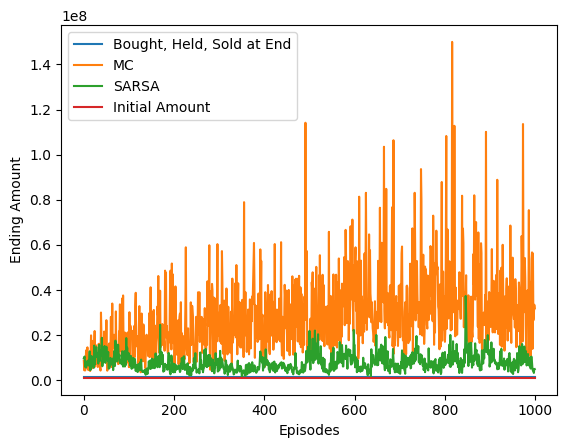

In [ ]:
starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value

end_value =trade[(trade['date'] == '2021-10-29') & (trade['tic'] == 'AAPL')]['open'].values[0]
end_amount_if_bought_and_held = end_value * stocks

plt.plot(list(range(EPISODES)), [end_amount_if_bought_and_held] * EPISODES, label='Bought, Held, Sold at End')
plt.plot(list(range(EPISODES)), two_step_sarsa_final_amounts, label='2-Step SARSA')
plt.plot(list(range(EPISODES)), four_step_sarsa_final_amounts, label='4-Step SARSA')
plt.plot(list(range(EPISODES)), ten_step_sarsa_final_amounts, label='10-Step SARSA')
plt.plot(list(range(EPISODES)), twenty_step_sarsa_final_amounts, label='20-Step SARSA')
plt.plot(list(range(EPISODES)), [1_000_000] * EPISODES, label='Initial Amount')
plt.xlabel('Episodes')
plt.ylabel('Ending Amount')
plt.legend()
plt.show()

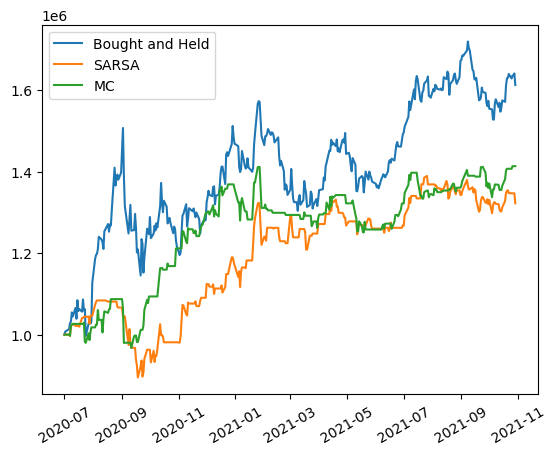

In [ ]:
#PLOT COMPARING PORTFOLIO VALUE OF TEST EPISODE AGAINST JUST HOLDING STOCK WITH SARSA AND MC

starting_value = trade[(trade['date'] == '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].values[0]
stocks = 1_000_000 / starting_value
values_while_held = trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'].to_numpy() * stocks
dates = np.asarray(trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['date'], dtype='datetime64[s]')
plt.plot(dates, values_while_held, label="Bought and Held")
two_step_sarsa_test_values = two_step_sarsa_test_env.asset_memory
plt.plot(dates, two_step_sarsa_test_env, label="2-Step SARSA")
four_step_sarsa_test_values = four_step_sarsa_test_env.asset_memory
plt.plot(dates, four_step_sarsa_test_env, label="4-Step SARSA")
ten_step_sarsa_test_values = ten_step_sarsa_test_env.asset_memory
plt.plot(dates, ten_step_sarsa_test_env, label="10-Step SARSA")
twenty_step_sarsa_test_values = twenty_step_sarsa_test_env.asset_memory
plt.plot(dates, twenty_step_sarsa_test_env, label="20-Step SARSA")
plt.xticks(rotation=30)
plt.legend()
plt.show()


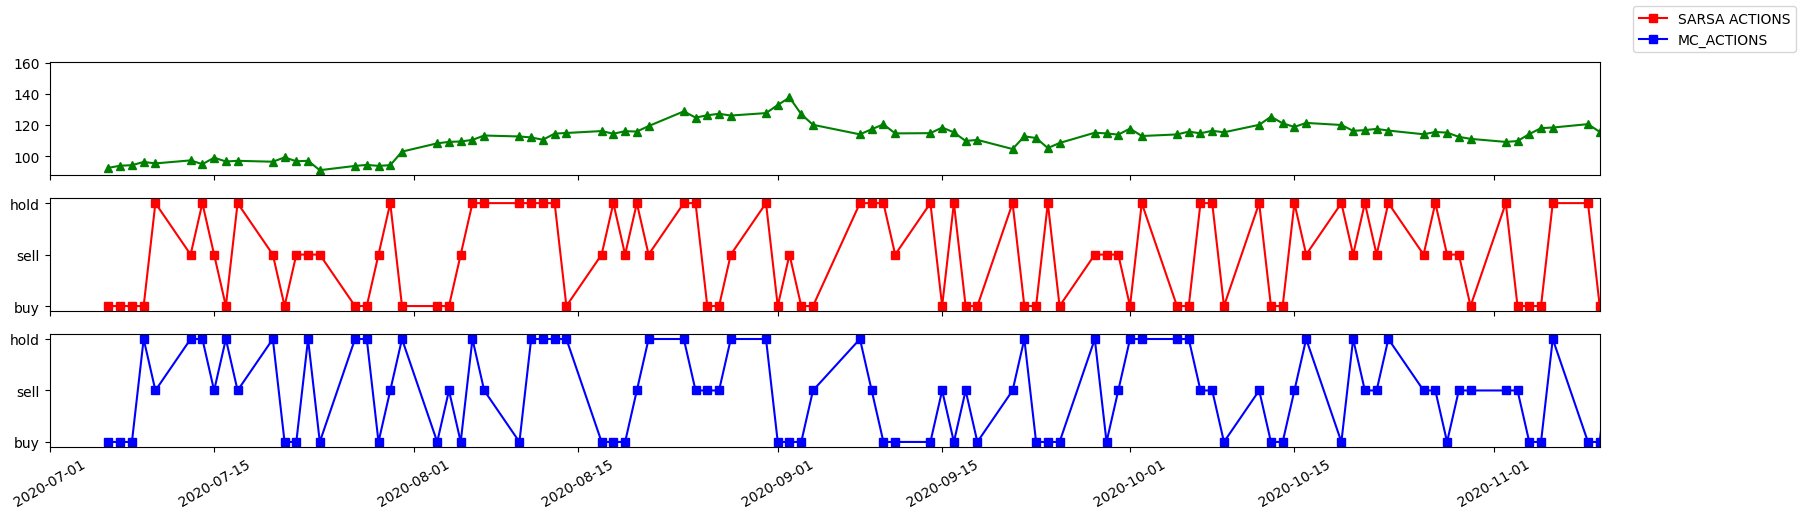

In [ ]:
# ACTIONS OVER TEST
two_step_sarsa_test_actions = []
four_step_sarsa_test_actions = []
ten_step_sarsa_test_actions = []
twenty_step_sarsa_test_actions = []
# episode.append((S, A, reward, percent))
action_dates = dates[2:] # account for skipping first two steps to create differences
for step in two_step_sarsa_test_episode[0]:
    action = step[1]
    two_step_sarsa_test_actions.append(action)
for step in four_step_sarsa_test_episode[0]:
    action = step[1]
    four_step_sarsa_test_actions.append(action)
for step in ten_step_sarsa_test_episode[0]:
    action = step[1]
    ten_step_sarsa_test_actions.append(action)
for step in twenty_step_sarsa_test_episode[0]:
    action = step[1]
    twenty_step_sarsa_test_actions.append(action)
fig, axs = plt.subplots(nrows=5, figsize=(20,5), sharex=True)
axs[1].plot(action_dates, two_step_sarsa_test_actions, marker = 's', label = '2-STEP SARSA ACTIONS', c='r')
axs[2].plot(action_dates, four_step_sarsa_test_actions, marker = 's', label = '4-STEP SARSA ACTIONS', c='b')
axs[3].plot(action_dates, ten_step_sarsa_test_actions, marker = 's', label = '10-STEP SARSA ACTIONS', c='c')
axs[4].plot(action_dates, twenty_step_sarsa_test_actions, marker = 's', label = '20-STEP SARSA ACTIONS', c='y')
fig.legend()
plt.xticks(rotation=30)

axs[0].plot(action_dates, trade[(trade['date'] >= '2020-07-01') & (trade['tic'] == 'AAPL')]['open'][2:], marker = '^', label = 'STOCK VALUE', c='g')
for ax in axs[1:]:
    ax.set_xlim(np.asarray(['2020-07-01', '2020-11-10'],  dtype='datetime64[s]'))
    ax.set_yticks([0, 1, 2]) # buy hold sell
    ax.set_yticklabels(['buy', 'sell', 'hold'])


In [ ]:
# LENGTH OF EPISODES and Q TABLE SIZE PLOT